In [2]:
from utils import *
from plotting import *
from models import *

plt.offline.init_notebook_mode()
plt.io.templates.default = "none"


Loaded configuration file /lila/home/harrigan/.local/share/jupyter/runtime/kernel-0f746894-e23a-4a63-890f-c12a61299c8e.json


Get count data

In [3]:
def load_counts(counts_fn, types_fn, type_subset=None):
    
    # probably don't want str input
    if isinstance(type_subset, str):
        warnings.warn("For str type_subset, each letter is matched. Are you sure you don't want list?", UserWarning)
        
    counts = pd.read_csv(counts_fn, index_col = [0], header = [0])[mut96]
    cancer_types = pd.read_csv(types_fn)
    cancer_types.columns=['type', 'guid']
    
    # subset guid by matching cancer type
    if type_subset is not None:
        
        # partial matches allowed
        sel = np.fromiter((map(any, zip(*[cancer_types.type.str.contains(x) for x in type_subset] ))), dtype = bool)
        
        # type should appear in the type column of the lookup 
        assert sel.any(), 'Cancer type subsetting yielded no selection. Check keywords?'
        
        counts = counts.loc[cancer_types.guid[sel]]

    return counts#.to_numpy()

In [4]:
#def load_metadata(mcols_file):
    # load any metadata associated with each sample by guid

In [5]:
counts = load_counts('mutation_types_raw_counts.csv', 'pcawg_cancer_types.csv', ['ColoRect'])
mcols = pd.read_csv('icgc_sample_annotations_summary_table.txt', sep='\t').set_index('tumour_aliquot_id').loc[counts.index]
counts = counts.to_numpy()
#train, test = split_by_S(counts)
#trp, trpp = split_by_count(train)
#tsp, tspp = split_by_count(test)

In [6]:
# constants
C = 32
M = 3

J=5
K=5

N = counts.sum(1)
S = len(N)
print(S)

60


Get signature data

In [7]:
cosmic = load_sigs('COSMIC_v3.2_SBS_GRCh37.txt', 'cosmic', sep = '\t')
pcawg_local = load_sigs('pcawg_localsigs.csv')
degas_local = load_sigs('degasperi_localsigs.csv', 'cosmic')

In [8]:
# get signature names
cosmic_names = np.array(cosmic.columns)
pcawg_names = np.array(pcawg_local.columns)
degas_names = np.array(degas_local.columns)

# turn signatures to numpy for sanity
cosmic = cosmic.to_numpy().T
pcawg_local = pcawg_local.to_numpy().T
degas_local = degas_local.to_numpy().T

# subset to skin-active signatures
np.where(np.array(cosmic_names) == 'SBS18')

cosmic_names[[62, 63, 12, 34]]
#pcawg_names[[]]

array(['SBS56', 'SBS57', 'SBS10a', 'SBS28'], dtype=object)

In [9]:
counts.shape
#plot_sigs(train, row_title='Sample').update_layout(height = 10000)

(60, 96)

Preview samples

In [10]:
from sklearn.decomposition import PCA
from plotly.subplots import make_subplots


def plot_pca(X, n_comp=10, mcol=None):
    fig = make_subplots(rows=1, cols=2)
    # X is row-data
    pca = PCA(n_components=n_comp)
    X_pca = pca.fit_transform(X)
    # plot PC elbow
    r = pca.explained_variance_ratio_
    fig.add_trace(go.Scatter(x=np.arange(len(r)), y=r, mode='lines+markers',
                             name = '% variance explained'), row=1, col=1)
    
    # plot PC 1 & 2
    fig.add_trace(go.Scatter(x=X_pca[:, 0], y=X_pca[:, 1],
                             marker=dict(color=mcol, #set color equal to a variable
                                         colorscale='Agsunset',
                                         showscale=(mcol is not None),
                                         colorbar=dict(len=0.5)
                                        ),
                             mode='markers', name='pc1/2'), row = 1, col = 2)
    
    return fig
    

plot_pca(counts,10, mcol = mcols.num_subclones).show()

In [11]:
centroids = init_sigs('kmeans', data=counts, J=J, K=K)
plot_sigs(centroids['phi'], cols = '#a64d79', xlab=mut32, row_title = 'Phi').update_layout(height = 500).show()
plot_sigs(centroids['eta'].reshape(-1,6), cols = '#45818e', xlab = mut6, row_title = 'Eta').update_layout(height = 500).show()

In [12]:
#def plotly_grid(list_of_plots, grid_matrix):
#    # unpack plots to place them all on a subplot matrix
#    traces = np.concatenate([np.array([*p.data]) for p in list_of_plots])
#    fig = go.make_subplots()
#    for t, r, c in zip(traces, grid_matrix):
#        fig.add_trace(t, row=r, col=c)
#    return fig

use model factory to amend size conflicts in test

In [13]:
model = collapsed_model_factory(counts, J, K, 1, 1, 1, 1, init_strategy = 'kmeans') 

In [14]:
with model:
    trace = pm.fit(30000, method='advi')
    baby_trace = pm.fit(1,method="advi")

In [15]:
#pm.plot_posterior(mean_field.sample(1000), color="LightSeaGreen");

Diagnostic plots

In [16]:
fig = go.Figure(data=go.Scatter(x=np.arange(trace.hist.shape[0]), y=trace.hist))
fig.update_layout(title="ELBO", xaxis_title = 'iteration', height = 400)

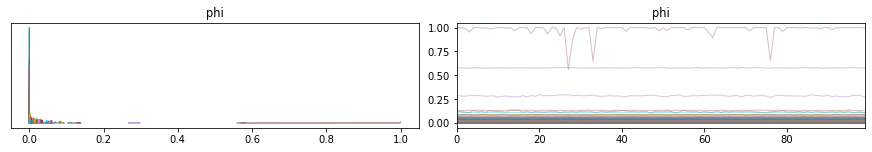

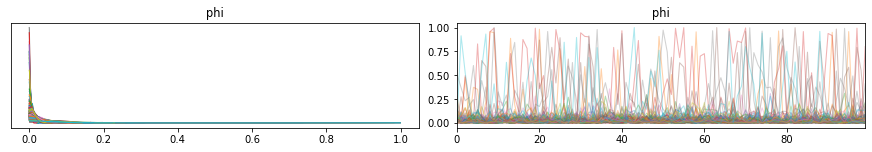

In [17]:
with model:
    #pm.plot_trace(trace.sample(100), var_names = 'theta');
    #pm.plot_trace(trace.sample(100), var_names = 'A');
    pm.plot_trace(trace.sample(100), var_names = 'phi');
    #pm.plot_trace(trace.sample(100), var_names = 'eta');
    pm.plot_trace(baby_trace.sample(100), var_names = 'phi');

In [18]:
hat = trace.sample(1000)

In [19]:
#plot_phi_posterior(baby_trace.sample(1000).phi, cols = None)

In [20]:
#plot_phi_posterior(trace.sample(1000).phi, cols = None)

In [21]:
plot_mean_std(hat.A)

In [22]:
w = np.einsum('tsj,tsjk -> tsjk', hat.theta, hat.A).mean(0)
plot_mean_std(w)

In [23]:
plot_pca(hat.A.mean(0).reshape(-1, J*K), 10)

In [24]:
mcols.columns

Index(['histology_abbreviation', 'icgc_sample_id', 'purity', 'ploidy',
       'wgd_status', 'purity_conf_mad', 'num_subclones', 'num_clonal_snvs',
       'num_subclonal_snvs', 'num_clonal_indels', 'num_subclonal_indels',
       'num_clonal_svs', 'num_subclonal_svs', 'icgc_donor_id', 'tumour_type',
       'reported_sex', 'inferred_sex', 'donor_survival_time',
       'donor_age_at_diagnosis', 'tumour_stage', 'tumour_grade',
       'first_therapy_type', 'first_therapy_response',
       'specimen_donor_treatment_type', 'cov_tumour', 'cov_normal', 'nrpcc',
       'is_preferred'],
      dtype='object')

In [25]:
for i in range(len(mcols.columns)):
    
    if mcols.dtypes[i] == float:
        f = plot_pca(hat.A.mean(0).reshape(-1, J*K), 10, mcol = mcols[mcols.columns[i]])
        f.update_layout(title=f"coloured by {mcols.columns[i]}", height = 500)
        f.show()
        
    else:
        f = plot_pca(hat.A.mean(0).reshape(-1, J*K), 10, mcol = mcols[mcols.columns[i]].astype('category').cat.codes)
        f.update_layout(title=f"coloured by {mcols.columns[i]}", height = 500)
        f.show()
    


In [26]:
# color by theta for each context signature
for j in range(J):
    f = plot_pca(hat.A.mean(0).reshape(-1, J*K), 10, mcol = hat.theta.mean(0)[:,j])
    f.update_layout(title=f"coloured by activity of context signature {j}", height = 500)
    f.show()

In [27]:
for i in range(len(mcols.columns)):
    
    if mcols.dtypes[i] == float:
        f = plot_pca(w.reshape(-1, J*K), 10, mcol = mcols[mcols.columns[i]])
        f.update_layout(title=f"coloured by {mcols.columns[i]}", height = 500)
        f.show()
        
    else:
        f = plot_pca(w.reshape(-1, J*K), 10, mcol = mcols[mcols.columns[i]].astype('category').cat.codes)
        f.update_layout(title=f"coloured by {mcols.columns[i]}", height = 500)
        f.show()
    


In [28]:
for j in range(J):
    f = plot_pca(w.reshape(-1, J*K), 10, mcol = hat.theta.mean(0)[:,j])
    f.update_layout(title=f"coloured by activity of context signature {j}", height = 500)
    f.show()

In [29]:
def plot_bipartite(w, rescale = 10, direction = 'forward', 
                   main = '', ah=0, log_weights = False,
                   edge_cols = '#000000', node_cols=['#a64d79', '#45818e', '#45818e']):
    # create fully connected, directional bipartite graph 
    # input is JxK matrix st w[j,k] gives the (possibly 0) weight 
    # of edge spannig nodes j to k. 
    assert len(w.shape) == 2
    J,K = w.shape
    
    if len(edge_cols) == 1:
        edge_cols = [edge_cols] * J*K
        
    else: 
        assert len(edge_cols) == J*K
    
    y0s = np.arange(J) - np.arange(J).mean()
    y1s = np.arange(K) - np.arange(K).mean()
    node_y = np.array([[y0, y1, None] for y0 in y0s for y1 in y1s]).flatten()
    node_x = np.array([[0, 1, None] for y0 in y0s for y1 in y1s]).flatten()
    
    fig = go.Figure()
    
    # plot each edge with its weight
    i=-1
    for y0 in y0s:
        for y1 in y1s:
            i+=1
            
            if direction == 'forward': 
                source = (0.003*rescale, y0)
                target = (1-(0.003*rescale), y1)
            else:
                target = (0.003*rescale, y0)
                source = (1-(0.003*rescale), y1)
                
            if w.flatten()[i] > 0.1:
                
                if log_weights:
                    weights = max(0.01, np.log(w.flatten()[i] * rescale))
                
                else:
                    weights = w.flatten()[i] * rescale
                
                fig.add_annotation(x=source[0], y = source[1],
                                   xref="x", yref="y",
                                   text="",
                                   showarrow=True,
                                   axref = "x", ayref='y',
                                   ax= target[0],
                                   ay= target[1],
                                   arrowhead = ah,
                                   arrowwidth= weights,
                                   arrowcolor=edge_cols[i]
                               )
    
                # add tiny jitter to show all overlapping points.
                fig.add_trace(go.Scatter(x=[0.5], y=[(y0+y1)/2] + pm.Normal.dist(0,0.001).random(),
                                marker=dict(size = 0.001),
                                hovertemplate=f'{w.flatten()[i].round(2)}',
                                mode='markers'))
                
    # plot nodes
    fig.add_trace(go.Scatter(x=node_x, y=node_y,
                             marker=dict(size = 40, color=([node_cols[0], node_cols[1], node_cols[1]] * 3*J*K)),
                             hoverinfo='none',
                             mode='markers'))
    
    fig.update_layout(
                title=main,
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
                   

    return fig


In [132]:
def plot_bipartite(w, rescale = 10, main = '', ah=0, thresh = 0.01,
                   edge_cols = '#000000', node_cols=['#a64d79', '#45818e']):
    # create fully connected, directional bipartite graph 
    # input is JxK matrix st w[j,k] gives the (possibly 0) weight 
    # of edge spannig nodes j to k. 
    assert len(w.shape) == 2
    J,K = w.shape
    
    if len(edge_cols) == 1:
        edge_cols = [edge_cols] * J*K
        
    else: 
        assert len(edge_cols) == J*K
        
    if np.any(w > 1):
        warnings.warn("Some w's >1. Edge width may be misleading.")
    
    if np.any(w < 0):
        warnings.warn("Some w's <0. Edge width may be misleading")
    
    
    y0s = np.arange(J) - np.arange(J).mean()
    y1s = np.arange(K) - np.arange(K).mean()
    node_y = np.array([[y0, y1, None] for y0 in y0s for y1 in y1s]).flatten()
    node_x = np.array([[0, 1, None] for y0 in y0s for y1 in y1s]).flatten()
    
    w = w.flatten()
    edges = w / np.max(w) * 10
    
    fig = go.Figure()
    
    # plot each edge with its weight
    
    i=-1
    for y0 in y0s:
        for y1 in y1s:
            i += 1
            source = (0.03, y0)
            target = (1-0.03, y1)
                
            if edges[i] > (thresh*10):
                fig.add_annotation(x=source[0], y = source[1],
                                   xref="x", yref="y",
                                   text="",
                                   showarrow=True,
                                   axref = "x", ayref='y',
                                   ax= target[0],
                                   ay= target[1],
                                   arrowhead = ah,
                                   arrowwidth= edges[i],
                                   arrowcolor=edge_cols[i]
                               )
    
            # add tiny jitter to show all overlapping points.
            fig.add_trace(go.Scatter(x=[0.5], y=[(y0+y1)/2] + pm.Normal.dist(0,0.001).random(),
                            marker=dict(size = 0.001),
                            hovertemplate=f'{w.flatten()[i].round(2)}',
                            mode='markers'))
            
    # plot nodes
    fig.add_trace(go.Scatter(x=node_x, y=node_y,
                             marker=dict(size = 40, color=([node_cols[0], node_cols[1], node_cols[1]] * 3*J*K)),
                             hoverinfo='none',
                             mode='markers'))
    
    fig.update_layout(
                title=main,
                titlefont_size=16,
                showlegend=False,
                hovermode='closest',
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
    )
                   

    return fig


In [133]:
n_comp = 2
pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(hat.A.mean(0).reshape(-1, J*K))

for i in range(n_comp):
    edges = pca.components_.reshape(-1, J, K)[i]
    edge_colours = np.tile('#f6b26b', J*K)
    edge_colours[edges.flatten() < 0] = '#6fa8dc'
    plot_bipartite(abs(edges), edge_cols = edge_colours, thresh = 0.1).show()


In [138]:
n_comp = 2
pca = PCA(n_components=n_comp)
X_pca = pca.fit_transform(w.reshape(-1, J*K))

for i in range(n_comp):
    edges = pca.components_.reshape(-1, J, K)[i]
    edge_colours = np.tile('#f6b26b', J*K)
    edge_colours[edges.flatten() < 0] = '#6fa8dc'
    plot_bipartite(abs(edges), edge_cols = edge_colours).show()


In [ ]:
#PCA(n_components=2).fit_transform(w.reshape(-1, J*K))
#km = k_means(w.reshape(-1, J*K), 7)

In [ ]:
plot_sigs(hat.phi.mean(0), cols = '#a64d79', xlab=mut32, row_title = 'Phi').update_layout(height = 500).show()
plot_sigs(hat.eta.mean(0).reshape(-1,6), cols = '#45818e', xlab = mut6, row_title = 'Eta').update_layout(height = 500).show()

In [ ]:
go.Figure(go.Heatmap(z=cosine_similarity(hat.phi.mean(0),hat.phi.mean(0)).round(2), colorscale = 'viridis'))

In [ ]:
go.Figure(go.Heatmap(z=cosine_similarity(flatten_eta(hat.eta.mean(0)),flatten_eta(hat.eta.mean(0))).round(2), colorscale = 'viridis'))

In [ ]:
tau_hat = get_tau(hat.phi.mean(0),hat.eta.mean(0))
plot_tau(tau_hat).show()

In [ ]:
#go.Figure(go.Heatmap(z=cosine_similarity(tau_hat,tau_hat).round(2), colorscale = 'viridis'))

In [ ]:
plot_cossim(get_phis(pcawg_local), hat.phi.mean(0))

In [ ]:
plot_cossim(pcawg_local, tau_hat)

In [ ]:
plot_cossim(get_phis(cosmic), hat.phi.mean(0))

In [ ]:
plot_cossim(cosmic, tau_hat)

In [ ]:
plot_cossim(get_etas(cosmic), get_etas(cosmic))

In [ ]:
cosmic_names[np.any(cosine_similarity(tau_hat,cosmic) > 0.9, axis = 0)]

In [ ]:
cosmic_names[np.any(cosine_similarity(hat.phi.mean(0), get_phis(cosmic) ) > 0.9, axis = 0)]

In [ ]:
cosmic_names[np.any(cosine_similarity(hat.eta.mean(0).reshape(-1,6), get_etas(cosmic) ) > 0.9, axis = 0)]

import arviz as az
with model:
    ppc = pm.sample_posterior_predictive(trace.sample(100), var_names=["corpus"])
    
az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model));

ppc['corpus'].shape